In [9]:
pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 48.7 MB/s eta 0:00:00


pandas (pd) — used for loading and manipulating structured data in tabular form (DataFrames).

numpy (np) — provides mathematical operations and numerical array handling for data processing.

rdkit — a chemistry-focused Python library used to interpret SMILES strings and extract molecular descriptors:

Chem handles molecular structures and conversions.

Descriptors provides built-in functions to compute molecular properties such as molecular weight.

CalcNumAromaticRings counts how many aromatic rings a molecule contains.

scikit-learn (sklearn) — used for building and evaluating regression models:

train_test_split divides data into training and testing subsets.

LinearRegression fits a linear regression model to predict melting and boiling points.

r2_score, mean_absolute_error, and mean_squared_error evaluate model performance.

matplotlib.pyplot (plt) and seaborn (sns) — visualization libraries used to create plots and compare predicted vs. actual values of molecular properties.

In [11]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.rdMolDescriptors import CalcNumAromaticRings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('hydrocarbons.csv')

In [5]:
df.head()

,Class of hydrocarbon,IUPAC name,Melting point,Boiling point,Density,Flash point,Autoignition temp,pubchem_id,smiles
0,Trimetylalkane,"2,2,4-Trimethylpentane",-107.0,99.0,0.69,NaN,396,10907,CC(C)CC(C)(C)C
1,Triaromatics,Phenanthrene,99.0,338.0,1.18,171,>450,995,C1=CC=C2C(=C1)C=CC3=CC=CC=C32
2,Triaromatics,Anthracene,216.0,341.0,1.2825,NaN,NaN,8418,C1=CC=C2C=C3C=CC=CC3=CC2=C1
3,Triaromatics,1-methylanthracene,86.0,342.0,1.04799,NaN,NaN,11884,CC1=CC=CC2=CC3=CC=CC=C3C=C12
4,Triaromatics,2-methylanthracene,209.0,340.0,1.8,NaN,NaN,11936,CC1=CC2=CC3=CC=CC=C3C=C2C=C1


In [8]:
df.isnull().sum()

,0
Class of hydrocarbon,0
IUPAC name,0
Melting point,6
Boiling point,4
Density,5
Flash point,117
Autoignition temp,131
pubchem_id,0
smiles,0


In [14]:
df.shape

(194, 9)

The line below removes any rows in the dataset where the melting point or boiling point values are missing (NaN).

dropna(subset=["Melting point", "Boiling point"])
→ Drops only those rows that have missing values in the specified columns (the target variables for our regression models).
→ We keep all other rows, even if other columns (like Density, Flash point, or Autoignition temp) still have missing values, because they are not used in the model.

reset_index(drop=True)
→ Resets the DataFrame’s index after dropping rows so that it runs sequentially from 0 again, avoiding gaps in the index.

##Why This Step Matters

Since the goal is to predict melting and boiling points, the model needs complete data for those target variables.
Removing rows with missing target values ensures that:

The regression model can be trained properly, and

There are no errors or distortions caused by missing targets.

In [16]:
df = df.dropna(subset=["Melting point", "Boiling point"]).reset_index(drop=True)

In [19]:
df.isnull().sum()

,0
Class of hydrocarbon,0
IUPAC name,0
Melting point,0
Boiling point,0
Density,2
Flash point,109
Autoignition temp,123
pubchem_id,0
smiles,0


The resultant df after dropping rows from the target columns:

In [21]:
df.shape

(186, 9)

This function takes a molecule’s SMILES (Simplified Molecular Input Line Entry System) string as input and extracts two key chemical features using RDKit.

Chem.MolFromSmiles(smiles)

→ Converts the SMILES string into an RDKit molecule object that can be analyzed.

→ If the SMILES string is invalid or cannot be parsed, the function returns two NaN values to indicate missing data.

Descriptors.MolWt(mol)

→ Calculates the molecular weight (the sum of the atomic masses of all atoms in the molecule).

CalcNumAromaticRings(mol)

→ Counts the number of aromatic rings (stable ring structures found in compounds like benzene).

pd.Series([mw, aromatic_rings])

→ Returns both computed values as a pandas Series so they can be easily added as new columns in the main DataFrame.

##Purpose

This function transforms the chemical structure information encoded in SMILES strings into numerical descriptors that can be used as input features for regression modeling.
These descriptors — molecular weight and aromatic ring count — are essential predictors for estimating melting and boiling points of hydrocarbons.

In [23]:
def extract_molecular_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return pd.Series([np.nan, np.nan])
    mw = Descriptors.MolWt(mol)
    aromatic_rings = CalcNumAromaticRings(mol)
    return pd.Series([mw, aromatic_rings])

This line applies the previously defined extract_molecular_features() function to each molecule in the dataset.

df["smiles"].apply(...)

→ Iterates over every SMILES string in the "smiles" column and passes it into the extract_molecular_features function.

→ For each molecule, the function returns two values:

* MolecularWeight — calculated using RDKit’s Descriptors.MolWt()

* AromaticRings — calculated using CalcNumAromaticRings()

df[["MolecularWeight", "AromaticRings"]] = ...

→ Assigns these two returned values to new columns in the DataFrame named "MolecularWeight" and "AromaticRings".

##Purpose

This step enriches the original dataset by adding chemically meaningful descriptors derived from each molecule’s structure.
These new numerical features form the predictor variables (X) for the regression models that will later predict melting and boiling points.

In [24]:
df[["MolecularWeight", "AromaticRings"]] = df["smiles"].apply(extract_molecular_features)

In [25]:
df = df.dropna(subset=["MolecularWeight"]).reset_index(drop=True)
df.head()

,Class of hydrocarbon,IUPAC name,Melting point,Boiling point,Density,Flash point,Autoignition temp,pubchem_id,smiles,MolecularWeight,AromaticRings
0,Trimetylalkane,"2,2,4-Trimethylpentane",-107.0,99.0,0.69,NaN,396,10907,CC(C)CC(C)(C)C,114.232,0.0
1,Triaromatics,Phenanthrene,99.0,338.0,1.18,171,>450,995,C1=CC=C2C(=C1)C=CC3=CC=CC=C32,178.234,3.0
2,Triaromatics,Anthracene,216.0,341.0,1.2825,NaN,NaN,8418,C1=CC=C2C=C3C=CC=CC3=CC2=C1,178.234,3.0
3,Triaromatics,1-methylanthracene,86.0,342.0,1.04799,NaN,NaN,11884,CC1=CC=CC2=CC3=CC=CC=C3C=C12,192.261,3.0
4,Triaromatics,2-methylanthracene,209.0,340.0,1.8,NaN,NaN,11936,CC1=CC2=CC3=CC=CC=C3C=C2C=C1,192.261,3.0


Preparation of our two linear regression models:

In [27]:
X = df[["MolecularWeight", "AromaticRings"]]

In [28]:
y_melt = df["Melting point"]
y_boil = df["Boiling point"]

In [30]:
X_train, X_test, y_train_m, y_test_m = train_test_split(X, y_melt, test_size=0.2, random_state=42)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X, y_boil, test_size=0.2, random_state=42)


In [32]:
model_melt = LinearRegression()
model_melt.fit(X_train, y_train_m)
y_pred_melt = model_melt.predict(X_test)

* The R² value of 0.698 indicates a moderately strong relationship between the predictors (molecular weight and number of aromatic rings) and the melting point.
This suggests that these two molecular descriptors capture a significant portion of the factors influencing melting behavior.

* The MAE and RMSE values show that while predictions are reasonably accurate, there is still noticeable error — likely due to other chemical factors (e.g., molecular symmetry, branching, intermolecular forces) not represented in the model.

In [34]:
print("\n--- Melting Point Model ---")
print("R²:", r2_score(y_test_m, y_pred_melt))
print("MAE:", mean_absolute_error(y_test_m, y_pred_melt))
print("RMSE:", np.sqrt(mean_squared_error(y_test_m, y_pred_melt)))


--- Melting Point Model ---
R²: 0.6982773428799607
MAE: 35.907670888053445
RMSE: 43.469120853940915


* The scatter plot shows a positive correlation between actual and predicted values, supporting the relatively high R² score (~0.70).

* Some dispersion around the diagonal indicates residual error — reflecting factors that the simple linear model cannot fully capture.

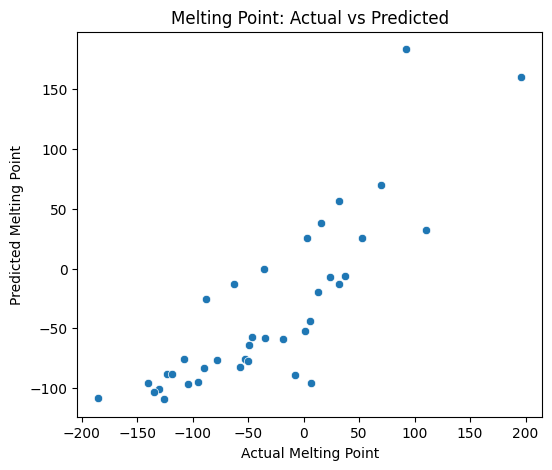

In [35]:
plt.figure(figsize=(6,5))
sns.scatterplot(x=y_test_m, y=y_pred_melt)
plt.xlabel("Actual Melting Point")
plt.ylabel("Predicted Melting Point")
plt.title("Melting Point: Actual vs Predicted")
plt.show()

In [36]:
model_boil = LinearRegression()
model_boil.fit(X_train_b, y_train_b)
y_pred_boil = model_boil.predict(X_test_b)

* The R² value of 0.91 indicates a very strong correlation between molecular descriptors (molecular weight and number of aromatic rings) and the boiling point.
This suggests the model captures most of the key factors influencing how hydrocarbons behave under heat.

* The MAE and RMSE values are both lower than those observed for the melting point model, confirming that boiling points are more predictable from these descriptors.

In [37]:
print("\n--- Boiling Point Model ---")
print("R²:", r2_score(y_test_b, y_pred_boil))
print("MAE:", mean_absolute_error(y_test_b, y_pred_boil))
print("RMSE:", np.sqrt(mean_squared_error(y_test_b, y_pred_boil)))


--- Boiling Point Model ---
R²: 0.908565068814377
MAE: 27.2379704621052
RMSE: 41.72931175698579


* The points in this plot are tightly clustered around the diagonal, reflecting the high R² value (~0.91).

* The small vertical deviations represent minor prediction errors, which are acceptable given the simplicity of the model.

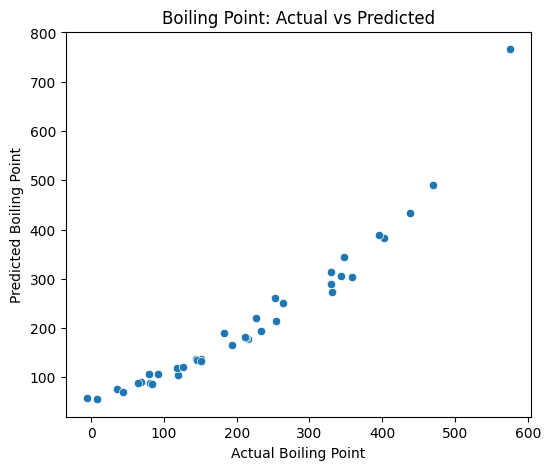

In [38]:
plt.figure(figsize=(6,5))
sns.scatterplot(x=y_test_b, y=y_pred_boil)
plt.xlabel("Actual Boiling Point")
plt.ylabel("Predicted Boiling Point")
plt.title("Boiling Point: Actual vs Predicted")
plt.show()

In [39]:
df_final = df[["IUPAC name", "MolecularWeight", "AromaticRings", "Melting point", "Boiling point"]]
df_final.head()

,IUPAC name,MolecularWeight,AromaticRings,Melting point,Boiling point
0,"2,2,4-Trimethylpentane",114.232,0.0,-107.0,99.0
1,Phenanthrene,178.234,3.0,99.0,338.0
2,Anthracene,178.234,3.0,216.0,341.0
3,1-methylanthracene,192.261,3.0,86.0,342.0
4,2-methylanthracene,192.261,3.0,209.0,340.0


##Challenges Encountered:
- Limited features made the models simple; only molecular weight and aromatic rings were used.
- Some SMILES strings failed to parse, requiring filtering.
- Boiling and melting points are influenced by many other molecular forces (e.g., polarity, branching, van der Waals interactions).

##Potential Improvements:
- Add more descriptors (e.g., TPSA, logP, rotatable bonds).
- Try non-linear models (Random Forest, Gradient Boosting).
- Normalize features to reduce scale differences between molecular weight and aromatic ring count.
- Increase dataset size for better generalization.
""")